In [1]:
import os
from classification_models.tfkeras import Classifiers

# Import the ResNet34 model
ResNet34, preprocess_input = Classifiers.get('resnet34')

In [2]:
# Run only for training!
import glob
import math
import datetime
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
import matplotlib.pyplot as plt
from IPython.display import Markdown, display
from sklearn.preprocessing import normalize

tfd = tfp.distributions
tfpl = tfp.layers
tfk = tf.keras
tfkl = tf.keras.layers

# Change parameters here...
log_dir = "logs/"
os.makedirs(log_dir, exist_ok=True)
data_dir = 'data/'
snapshot_weights = 'models/best_weights_xy_SGD_filter_steped_lr.hdf5'
last_snapshot_weights = 'models/last_weights_xy_SGD_filter_steped_lr.hdf5'

sizex = 500
sizey = 500
sizez = 3
rand_seed = 666
num_datasets = -1
batch_size = 32
nb_epochs = 200
validation_ratio = 0.2
#ds_size = len(data_dict['y_revs'])
ds_size = 250
buf_size = ds_size

In [3]:
# Collect all the .npz files
numpy_datasets = glob.glob(data_dir+'dataset*')

In [4]:
# load the data into a dictionary from npz files
data_dict = {}
for dataset in numpy_datasets[:num_datasets]:
    with np.load(dataset) as data:
        if 'y' in data_dict.keys():
            #data_dict['x_dust']   = np.append( data_dict['x_dust'], data['x_dust'],axis=0)
            data_dict['x_nodust'] = np.append( data_dict['x_nodust'], data['x_nodust'],axis=0)
            data_dict['y']        = np.append( data_dict['y'], data['y'],axis=0)
            data_dict['ids']      = np.append( data_dict['ids'], data['id'],axis=0)
        else:
            #data_dict['x_dust']   = data['x_dust']
            data_dict['x_nodust'] = data['x_nodust']
            data_dict['y']        = data['y']
            data_dict['ids']      = data['id']

In [5]:
# check the shape of the dictionary (100 images of 500x500x3 = 4 files of 25 images) before filtering
data_dict['x_nodust'].shape

(895, 500, 500, 3)

In [6]:
#Filter the galaxies that have less than 1e10 solar masses
bad_ids = [[galaxy_id,i] for galaxy_id,i in zip(data_dict['ids'],range(len(data_dict['ids']))) if 'e09' in galaxy_id or 'e10' in galaxy_id ]
bad_ids = np.array(bad_ids)
remove_galaxies = np.array(bad_ids[:,1],dtype=int)
print('there are ', len(bad_ids), ' galaxies to remove')
#print(remove_galaxies)
filtered_dict = {}

for key in data_dict.keys():
    data_dict[key] = np.delete(data_dict[key],remove_galaxies, axis=0)
    
print('Still have ', len(data_dict['ids']), ' galaxies left')

there are  490  galaxies to remove
Still have  405  galaxies left


In [7]:
# check that we hace filtered the correct galaxies
data_dict['ids'][:15]

array(['g5.38e11_x73_y33_z282', 'g5.38e11_x118_y115_z5',
       'g5.38e11_x4_y285_z273', 'g5.38e11_x207_y331_z254',
       'g5.38e11_x138_y82_z188', 'g5.46e11_x134_y99_z113',
       'g5.46e11_x111_y17_z326', 'g5.46e11_x311_y196_z302',
       'g5.46e11_x306_y325_z297', 'g5.46e11_x50_y326_z189',
       'g5.55e11_x310_y321_z331', 'g5.55e11_x7_y92_z328',
       'g5.55e11_x245_y211_z81', 'g5.55e11_x245_y339_z176',
       'g5.55e11_x342_y14_z192'], dtype='<U23')

In [8]:
# check the shape of the dictionary after filtering
data_dict['x_nodust'].shape

(405, 500, 500, 3)

In [9]:
# Compute the angles from the x,y,z labels
# theta = np.arctan(np.sqrt(x**2 + y**2)/z)
# phi = np.arctan(y/x)
def cart_to_esf(xyz):
    angles = np.empty( (len(xyz),2) )
    angles[:,0] = np.arctan2(np.sqrt(xyz[:,0]**2 + xyz[:,1]**2),xyz[:,2]) *180/np.pi #theta angle in degrees
    angles[:,1] = np.arctan2(xyz[:,1],xyz[:,0]) * 180/np.pi #phi angle in degrees
    return angles

# Define the function to go back to cartisian cordinates
def esf_to_cart(angles):
    xyz = np.empty( (len(angles),3) )
    ang_rad = angles*np.pi/180
    xyz[:,0] = np.sin(ang_rad[:,0])*np.cos(ang_rad[:,1])
    xyz[:,1] = np.sin(ang_rad[:,0])*np.sin(ang_rad[:,1])
    xyz[:,2] = np.cos(ang_rad[:,0])
    return xyz

#break the degeneracy of the solutions restricting the solution to 1 sector
def break_degeneracy(angles):
    ang_norm = angles
    for i in range(len(angles)):
        if ang_norm[:,1][i] < 0:
            ang_norm[:,1][i] = (ang_norm[:,1][i] + 180)
    return ang_norm

#map the solution to be between [0,1]
def map_to_1(angles, max = 180 ):
    ang_norm = angles/max
    return ang_norm

#coming back the mapping from 1 to 180
def map_to_180(ang_norm):
  angle = ang_norm*180
  return angle

# computing the normaliced vectors in 3D
data_dict['y_norm'] = normalize(data_dict['y'], axis=1)
data_dict['y_ang'] = map_to_1(break_degeneracy(cart_to_esf(normalize(data_dict['y'], axis=1))))
data_dict['y_revs'] = esf_to_cart(map_to_180(data_dict['y_ang']))

In [10]:
# check the shape of our dictionary in te labels entry
print(data_dict['y_norm'].shape)

(405, 3)


In [11]:
# separate in batches and shuffle the data with a fixed seed
#dataset = dataset.batch(batch_size)
#dataset = dataset.shuffle(10, seed=123)
AUTO = tf.data.experimental.AUTOTUNE

In [12]:
# functions to visualice the data 
def viz(img, label, pred=np.array([0,0,0]), id=None):
    fig, ax = plt.subplots(figsize=(5,5))
    im = ax.imshow(img, cmap='gray', vmin=0, vmax=255,origin='lower')
    ax.arrow(250,250,100*label[0],100*label[1], head_width=7, head_length=10, fc='g', ec='g')
    if np.sum(np.abs(pred)) > 0: ax.arrow(250,250,100*pred[0],100*pred[1], head_width=7, head_length=10, fc='r', ec='r')
        
    display(Markdown("#### **cartesian label:** {}".format(label)))
    if np.sum(np.abs(pred)) > 0: display(Markdown("#### **cartesian prediction (x_y):** {}".format(pred)))
    if id: display(Markdown("#### **ID:** {}".format(id)))
    plt.show()

# create the dataset from the dictionary and see the size and type
dataset = tf.data.Dataset.from_tensor_slices(data_dict)
print(dataset)

<TensorSliceDataset shapes: {x_nodust: (500, 500, 3), y: (3,), ids: (), y_norm: (3,), y_ang: (2,), y_revs: (3,)}, types: {x_nodust: tf.float64, y: tf.float64, ids: tf.string, y_norm: tf.float64, y_ang: tf.float64, y_revs: tf.float64}>


#### **cartesian label:** [ 0.46680332  0.76074614 -0.45095452]

#### **cartesian prediction (x_y):** [ 0.46680332  0.76074614 -0.45095452]

#### **ID:** b'g3.23e11_x192_y238_z218'

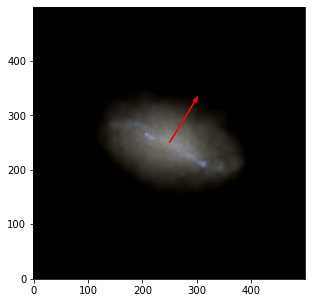

#### **cartesian label:** [0.25409979 0.44085076 0.8608623 ]

#### **cartesian prediction (x_y):** [0.25409979 0.44085076 0.8608623 ]

#### **ID:** b'g2.04e11_x32_y348_z247'

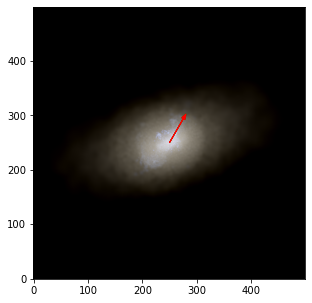

#### **cartesian label:** [-0.47901533 -0.07426079 -0.87465973]

#### **cartesian prediction (x_y):** [ 0.47901533  0.07426079 -0.87465973]

#### **ID:** b'g2.79e12_x52_y248_z101'

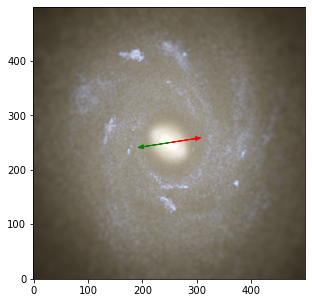

#### **cartesian label:** [-0.1562322   0.30773711  0.93855707]

#### **cartesian prediction (x_y):** [-0.1562322   0.30773711  0.93855707]

#### **ID:** b'g3.49e11_x261_y183_z222'

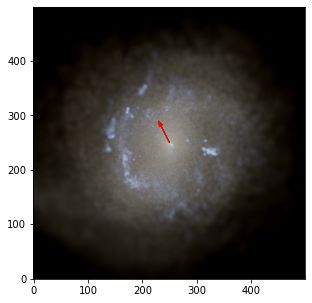

#### **cartesian label:** [ 0.18716548 -0.48423022  0.85468718]

#### **cartesian prediction (x_y):** [-0.18716548  0.48423022  0.85468718]

#### **ID:** b'g1.05e11_x241_y204_z49'

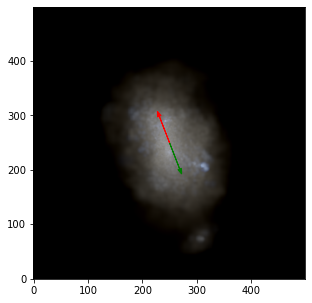

#### **cartesian label:** [-0.48457038  0.83954677 -0.24566803]

#### **cartesian prediction (x_y):** [-0.48457038  0.83954677 -0.24566803]

#### **ID:** b'g2.19e11_x189_y233_z34'

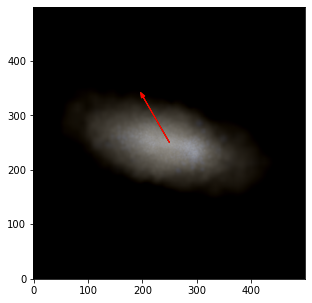

#### **cartesian label:** [ 0.30069015 -0.00199004  0.95371981]

#### **cartesian prediction (x_y):** [-0.30069015  0.00199004  0.95371981]

#### **ID:** b'g5.31e11_x50_y255_z112'

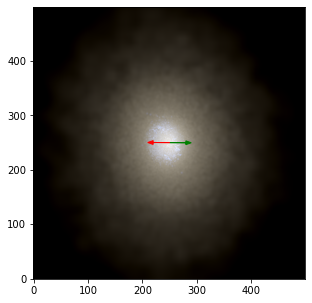

#### **cartesian label:** [ 0.84659725 -0.32004032 -0.42526143]

#### **cartesian prediction (x_y):** [-0.84659725  0.32004032 -0.42526143]

#### **ID:** b'g3.49e11_x40_y55_z229'

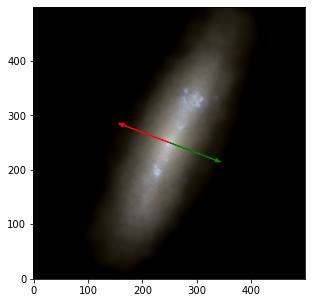

#### **cartesian label:** [-0.01737563 -0.14807151 -0.98882401]

#### **cartesian prediction (x_y):** [ 0.01737563  0.14807151 -0.98882401]

#### **ID:** b'g1.92e12_x342_y72_z264'

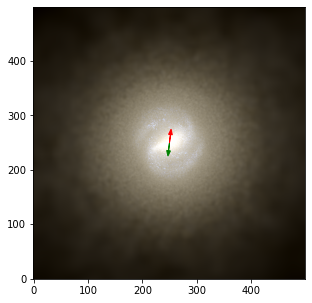

#### **cartesian label:** [-0.62686766  0.70078731  0.34049095]

#### **cartesian prediction (x_y):** [-0.62686766  0.70078731  0.34049095]

#### **ID:** b'g1.05e11_x130_y269_z141'

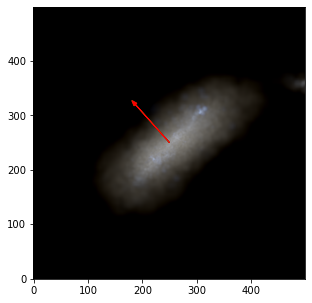

In [13]:
# visualice the data
real_dataset = dataset.batch(batch_size).shuffle(10, seed=rand_seed)
for idx in range(1,5):
    elements = real_dataset.take(idx)
    for elem in elements:
        viz(elem['x_nodust'][idx], elem['y_norm'][idx], elem['y_revs'][idx], id=elem['ids'][idx])

In [14]:
# defining the train and validation dataset from the existing dictionary, shufling and batching
input_ds = (
    tf.data.Dataset.from_tensor_slices((data_dict['x_nodust'].astype(np.float32), data_dict['y_norm'][:,:2].astype(np.float32)))
                    # Use seed to ensure we always have the same validation data set!
                   .shuffle(ds_size, seed = rand_seed, reshuffle_each_iteration = False)
)

input_ds = input_ds.take(ds_size)
val_size = math.floor(ds_size * validation_ratio)

validation_ds = ( input_ds.take(val_size).batch(batch_size) )
train_ds = ( input_ds.skip(val_size).shuffle(buffer_size=buf_size, reshuffle_each_iteration=True).batch(batch_size) )

print(train_ds)
print(validation_ds)

<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>
<BatchDataset shapes: ((None, 500, 500, 3), (None, 2)), types: (tf.float32, tf.float32)>


In [15]:
%reload_ext tensorboard
%tensorboard --logdir {log_dir} --reload_multifile True --host 0.0.0.0 --port 6006

In [18]:
# Build model
base_model = ResNet34(input_shape=(sizey,sizex,3), include_top=False)

# redefine the output to be 2 parameters from the last dense layer
x = tf.keras.layers.GlobalAveragePooling2D()(base_model.output)
output = tf.keras.layers.Dense(2, activation=None)(x)
model = tf.keras.models.Model(inputs=[base_model.input], outputs=[output])

# Use existing best weights if available...
if os.path.isfile(last_snapshot_weights):
    print('loaded weights')
    model.load_weights(last_snapshot_weights)
    
cossim = lambda y, p_y: -1*tf.keras.backend.abs(tf.keras.losses.cosine_similarity(y, p_y))
#define the learning rate schedule
def scheduler(epoch, lr):
    if epoch == 25:
        return lr / 10
    elif epoch == 100:
        return lr/10
    else:
        return lr


model.compile(optimizer= tf.keras.optimizers.SGD(),
              loss=cossim, metrics=[tf.keras.metrics.mean_squared_error, 
                                    tf.keras.metrics.mean_absolute_error, 
                                    tf.keras.metrics.mean_absolute_percentage_error])

In [ ]:
# model.summary()

# For tensorboard
log_dir_s = log_dir + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
os.makedirs(log_dir_s, exist_ok=True)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir_s, histogram_freq=1, update_freq='batch', profile_batch=0)

# Checkpointing
checkpointer_1 = tf.keras.callbacks.ModelCheckpoint(filepath=snapshot_weights,
                               monitor='mean_absolute_error',
                               verbose=1,
                               save_best_only=True)
checkpointer_2 = tf.keras.callbacks.ModelCheckpoint(filepath=last_snapshot_weights,
                               monitor='mean_absolute_error',
                               verbose=1,
                               save_best_only=False)

LearningRateScheduler = tf.keras.callbacks.LearningRateScheduler(scheduler)

callbacks = [
    tensorboard_callback,
    checkpointer_1,
    checkpointer_2,
    LearningRateScheduler
]

model.fit(
    train_ds,
    validation_data = validation_ds,
    epochs = nb_epochs,
    callbacks = callbacks,)
    # class_weight=class_weight)

Epoch 1/200
7/7 [==============================] - ETA: 0s - loss: -0.6552 - mean_squared_error: 0.8529 - mean_absolute_error: 0.7681 - mean_absolute_percentage_error: 494.8395
Epoch 00001: mean_absolute_error improved from inf to 0.76812, saving model to models/best_weights_xy_SGD_filter_steped_lr.hdf5

Epoch 00001: saving model to models/last_weights_xy_SGD_filter_steped_lr.hdf5
7/7 [==============================] - 51s 7s/step - loss: -0.6552 - mean_squared_error: 0.8529 - mean_absolute_error: 0.7681 - mean_absolute_percentage_error: 494.8395 - val_loss: -0.5643 - val_mean_squared_error: 2918.0957 - val_mean_absolute_error: 39.7127 - val_mean_absolute_percentage_error: 31113.0527 - lr: 0.0100
Epoch 2/200
7/7 [==============================] - ETA: 0s - loss: -0.7096 - mean_squared_error: 0.9110 - mean_absolute_error: 0.7705 - mean_absolute_percentage_error: 423.6376
Epoch 00002: mean_absolute_error did not improve from 0.76812

Epoch 00002: saving model to models/last_weights_xy_SG

In [ ]:
model.save('models/trained_xy_SGD_filter_steped_lr.h5')

In [ ]:
# taking samples from the validation dataset and evaluating the model
val_ex, = validation_ds.take(1)
images, labels = val_ex[0], val_ex[1]
outputs = model.predict(images)

In [ ]:
#print(labels)
print(outputs[:20])

In [ ]:
# visualicing the results
for img,label,pred,i in zip(images, labels, outputs,range(15)):
    viz(img, label, pred)